In [1]:
import os
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import warnings

# Preprocessing

In [2]:
train_path = "resources/dataset/train/"
test_path = "resources/dataset/test/"

In [3]:
train_dir = os.listdir(train_path)

In [4]:
ocean_train = os.listdir(train_path + "sea_ocean")
other_train = os.listdir(train_path + "other")
ocean_test = os.listdir(test_path + "sea_ocean")
other_test = os.listdir(test_path + "other")

In [5]:
heights = []
width = []
all_img = []

for img in ocean_train:
    img = Image.open(train_path + "sea_ocean/" + img)
    w, h = img.size
    heights.append(h)
    width.append(w)
    all_img.append(np.array(img))

for img in other_train:
    img = Image.open(train_path + "other/" + img)
    w, h = img.size
    heights.append(h)
    width.append(w)
    all_img.append(np.array(img))


In [6]:
mean_h = int(np.mean(heights))
mean_w = int(np.mean(width))
print(mean_h, mean_w)

413 657


Text(0, 0.5, 'Width')

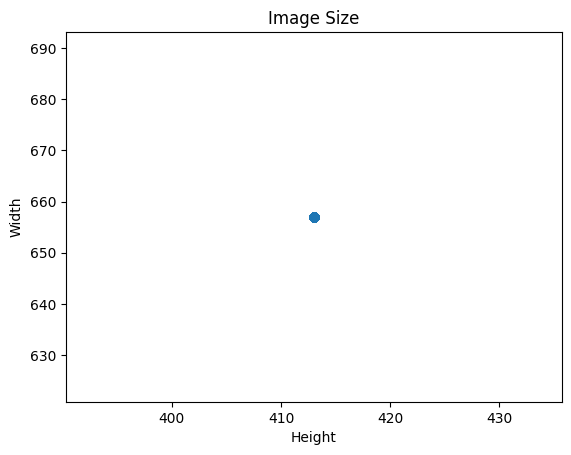

In [7]:
plt.scatter(heights, width)
plt.title("Image Size")
plt.xlabel("Height")
plt.ylabel("Width")

In [8]:
def normalise(repo_path, img_repo, class_name):
    for img in img_repo:
        name = img
        img = Image.open(repo_path + class_name + "/" + name)
        img = img.resize((int(mean_w), int(mean_h)))
        img = np.array(img)
        try:
            img = img[:, :, :3]
        except:
            print(name + " from " + str(repo_path))
        img = img[:, :, :3]
        img = Image.fromarray(img)
        img.save(f"{repo_path}{class_name}/{name}")

In [9]:
normalise(repo_path=train_path, img_repo=ocean_train, class_name="sea_ocean")
normalise(repo_path=train_path, img_repo=other_train, class_name="other")
normalise(repo_path=test_path, img_repo=ocean_test, class_name="sea_ocean")
normalise(repo_path=test_path, img_repo=other_test, class_name="other")

# Data Augmentation

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [11]:
train_data_generator = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    rescale=1/255.0
)

In [12]:
test_data_generator = ImageDataGenerator(rescale=1/255.0)
#train_data_generator = ImageDataGenerator(rescale=1/255.0)

# ImageDataGenerator

In [13]:
train_generator = train_data_generator.flow_from_directory(
    directory = train_path,
    target_size = (mean_w, mean_h),
    batch_size=32,
    class_mode="binary"

)

test_generator = test_data_generator.flow_from_directory(
    directory = test_path,
    target_size = (mean_w, mean_h),
    batch_size=32,
    class_mode="binary"
)

Found 294 images belonging to 2 classes.
Found 116 images belonging to 2 classes.


In [14]:
train_generator.class_indices

{'other': 0, 'sea_ocean': 1}

In [15]:
mean_w, mean_h

(657, 413)

# Model

In [16]:
def plot_curves(history):
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    ax[0].plot(list(range(len(history['loss']))), history['loss'], label = "loss")
    ax[0].plot(list(range(len(history['val_loss']))), history['val_loss'], label="val_loss")
    ax[0].set(xlabel="Epochs", ylabel="Loss")
    ax[0].set_title("Loss Curve")
    ax[0].legend(loc='upper right')
    ax[1].plot(list(range(len(history['accuracy']))), history['accuracy'], label = "accuracy")
    ax[1].plot(list(range(len(history['val_accuracy']))), history['val_accuracy'], label="val_accuracy")
    ax[1].set(xlabel="Epochs", ylabel="Accuracy")
    ax[1].set_title("Accuracy Curve")
    ax[1].legend(loc='upper right')

In [18]:
model = tf.keras.models.Sequential([

    tf.keras.layers.Conv2D(filters=32, kernel_size=(5, 5), padding="same", activation='relu', input_shape=(mean_h, mean_w, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(5, 5), activation="relu"),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(filters=128, kernel_size=(5, 5), activation="relu"),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(filters=128, kernel_size=(5, 5), activation="relu"),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Flatten(),

    # Dense
    tf.keras.layers.Dense(units=128, activation="relu"),
    tf.keras.layers.Dense(units=1, activation="sigmoid"),
                ])

model.compile(optimizer="adam",
              loss="binary_crossentropy",
              metrics=['accuracy'])
model_ckp = tf.keras.callbacks.ModelCheckpoint(filepath="model.h5",
                            monitor="val_accuracy",
                            mode="max",
                            save_best_only=True)
stop = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=3, restore_best_weights=True)

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 413, 657, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 206, 328, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 202, 324, 64)      51264     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 101, 162, 64)     0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 97, 158, 128)      204928    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 48, 79, 128)      0

In [20]:
h = model.fit(train_generator, epochs=50,
             validation_data=test_generator,
              callbacks=[model_ckp, stop]
             )

Epoch 1/50
10/10 [==============================] - 36s 2s/step - loss: 0.8396 - accuracy: 0.5544 - val_loss: 1.2115 - val_accuracy: 0.5000
Epoch 2/50
10/10 [==============================] - 10s 979ms/step - loss: 0.6182 - accuracy: 0.6939 - val_loss: 0.4800 - val_accuracy: 0.7759
Epoch 3/50
10/10 [==============================] - 10s 973ms/step - loss: 0.5449 - accuracy: 0.7041 - val_loss: 0.4715 - val_accuracy: 0.8448
Epoch 4/50
10/10 [==============================] - 10s 899ms/step - loss: 0.5212 - accuracy: 0.7789 - val_loss: 0.4350 - val_accuracy: 0.8190
Epoch 5/50
10/10 [==============================] - 10s 1s/step - loss: 0.5433 - accuracy: 0.7551 - val_loss: 0.5477 - val_accuracy: 0.6983
Epoch 6/50
10/10 [==============================] - 10s 949ms/step - loss: 0.5037 - accuracy: 0.7891 - val_loss: 0.5568 - val_accuracy: 0.7672


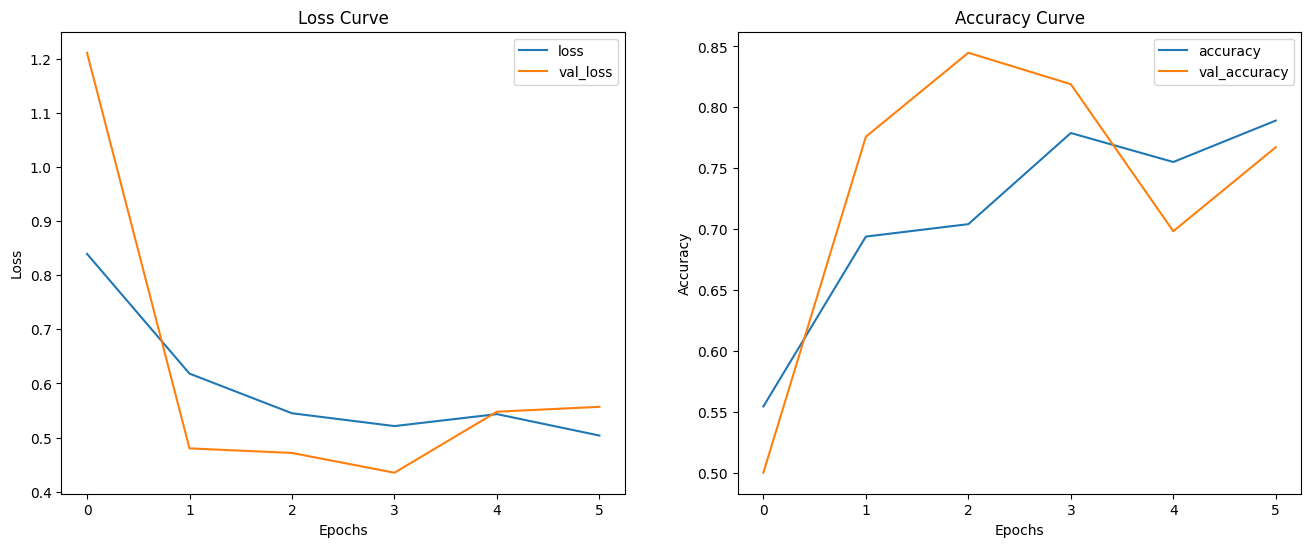

In [21]:
plot_curves(h.history)

In [22]:
model1 = tf.keras.models.Sequential([

    tf.keras.layers.Conv2D(filters=32, kernel_size=(5, 5), padding="same", activation='relu',
                           input_shape=(mean_h, mean_w, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(5, 5), activation="relu"),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(filters=128, kernel_size=(5, 5), activation="relu"),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(filters=128, kernel_size=(5, 5), activation="relu"),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(units=128, activation="relu"),
    tf.keras.layers.Dense(units=1, activation="sigmoid"),
])

model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss="binary_crossentropy",
              metrics=['accuracy'])
model_ckp = tf.keras.callbacks.ModelCheckpoint(filepath="model1.h5",
                            monitor="val_accuracy",
                            mode="max",
                            save_best_only=True)
stop = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=3, restore_best_weights=True)

In [23]:
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 413, 657, 32)      2432      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 206, 328, 32)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 202, 324, 64)      51264     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 101, 162, 64)     0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 97, 158, 128)      204928    
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 48, 79, 128)     

Epoch 1/50
10/10 [==============================] - 10s 933ms/step - loss: 3.3194 - accuracy: 0.4966 - val_loss: 0.6933 - val_accuracy: 0.5000
Epoch 2/50
10/10 [==============================] - 10s 949ms/step - loss: 0.7028 - accuracy: 0.4932 - val_loss: 0.6904 - val_accuracy: 0.5000
Epoch 3/50
10/10 [==============================] - 10s 946ms/step - loss: 0.6894 - accuracy: 0.4932 - val_loss: 0.6761 - val_accuracy: 0.5000
Epoch 4/50
10/10 [==============================] - 10s 972ms/step - loss: 0.6810 - accuracy: 0.5646 - val_loss: 0.6668 - val_accuracy: 0.5948
Epoch 5/50
10/10 [==============================] - 10s 971ms/step - loss: 0.6458 - accuracy: 0.5952 - val_loss: 0.6700 - val_accuracy: 0.6552
Epoch 6/50
10/10 [==============================] - 10s 954ms/step - loss: 0.6633 - accuracy: 0.6939 - val_loss: 0.6438 - val_accuracy: 0.6552
Epoch 7/50
10/10 [==============================] - 10s 974ms/step - loss: 0.6676 - accuracy: 0.6020 - val_loss: 0.6382 - val_accuracy: 0.7845

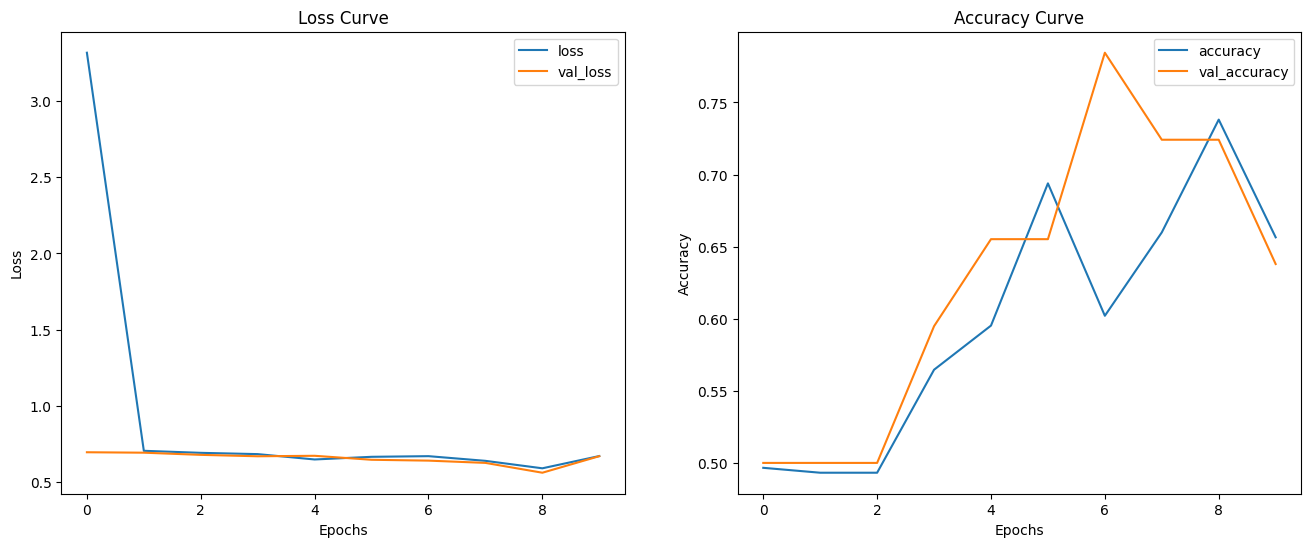

In [24]:
h1 = model1.fit(train_generator, epochs=50,
              validation_data=test_generator,
                callbacks=[model_ckp, stop])
plot_curves(h1.history)

In [20]:
model2 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=32, kernel_size=(5, 5), padding="same", activation='relu',
                           input_shape=(mean_h, mean_w, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(5, 5), activation="relu"),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(5, 5), activation="relu"),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(5, 5), activation="relu"),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(units=256, activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=1, activation="sigmoid"),
])

model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
               loss="binary_crossentropy",
               metrics=['accuracy'])

model_ckp = tf.keras.callbacks.ModelCheckpoint(filepath="dps_model.h5",
                            monitor="val_accuracy",
                            mode="max",
                            save_best_only=True)
stop = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=6, restore_best_weights=True)

In [21]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 413, 657, 32)      2432      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 206, 328, 32)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 202, 324, 64)      51264     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 101, 162, 64)     0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 97, 158, 64)       102464    
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 48, 79, 64)      

Epoch 1/50
10/10 [==============================] - 11s 1s/step - loss: 1.4182 - accuracy: 0.5238 - val_loss: 0.6944 - val_accuracy: 0.5000
Epoch 2/50
10/10 [==============================] - 10s 1s/step - loss: 0.7002 - accuracy: 0.4796 - val_loss: 0.6907 - val_accuracy: 0.6552
Epoch 3/50
10/10 [==============================] - 10s 990ms/step - loss: 0.6631 - accuracy: 0.6327 - val_loss: 0.5270 - val_accuracy: 0.7500
Epoch 4/50
10/10 [==============================] - 10s 962ms/step - loss: 0.6242 - accuracy: 0.7143 - val_loss: 0.5818 - val_accuracy: 0.7328
Epoch 5/50
10/10 [==============================] - 10s 990ms/step - loss: 0.5602 - accuracy: 0.7347 - val_loss: 0.4692 - val_accuracy: 0.7931
Epoch 6/50
10/10 [==============================] - 10s 960ms/step - loss: 0.5302 - accuracy: 0.7449 - val_loss: 0.4594 - val_accuracy: 0.7931
Epoch 7/50
10/10 [==============================] - 10s 960ms/step - loss: 0.5616 - accuracy: 0.7347 - val_loss: 0.5120 - val_accuracy: 0.7672
Epoch

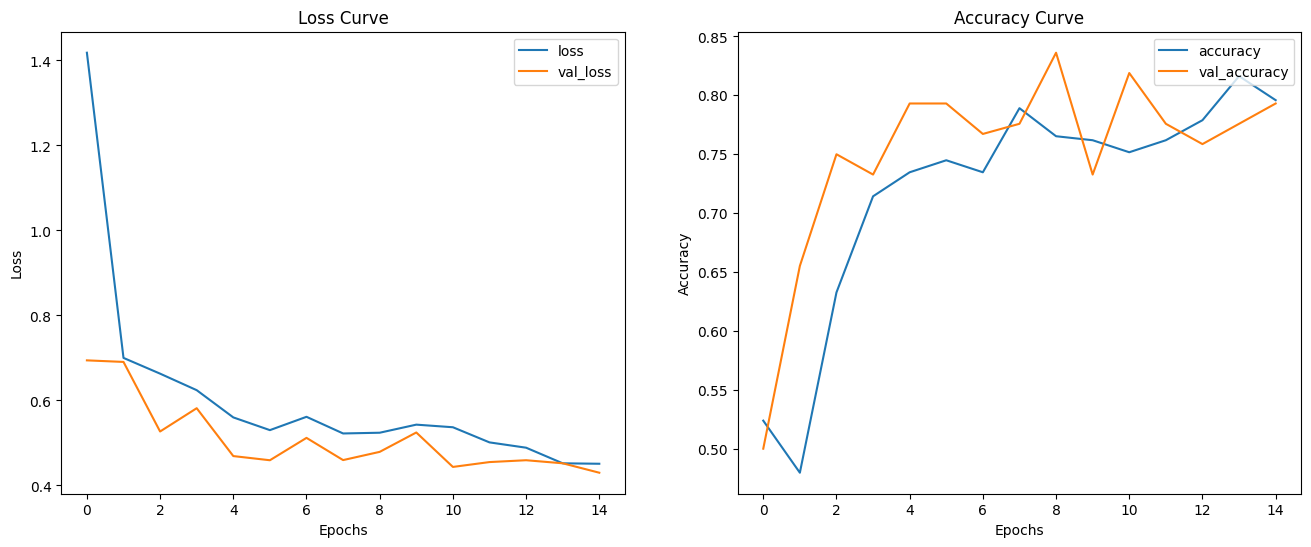

In [22]:
h2 = model2.fit(train_generator, epochs=50,
                validation_data=test_generator,
                callbacks=[model_ckp, stop]
                )
plot_curves(h2.history)

In [23]:
model2.evaluate(test_generator)

4/4 [==============================] - 1s 116ms/step - loss: 0.4791 - accuracy: 0.8362


[0.47910603880882263, 0.8362069129943848]

In [24]:
y_pred_prob = model2.predict(test_generator)
y_pred = np.where(y_pred_prob > 0.5, 1, 0)

y_true = test_generator.classes

precision = tf.keras.metrics.Precision()
precision.update_state(y_true, y_pred)
precision_result = precision.result().numpy()

recall = tf.keras.metrics.Recall()
recall.update_state(y_true, y_pred)
recall_result = recall.result().numpy()

f1 = 2 * (precision_result * recall_result) / (precision_result + recall_result + 1e-10)


print("Précision:", precision_result)
print("Rappel:", recall_result)
print("Score F1:", f1)

4/4 [==============================] - 1s 182ms/step
Précision: 0.55737704
Rappel: 0.5862069
Score F1: 0.5714285341493784


# Fine Tuning Resnet

In [47]:
from tensorflow.keras.applications import vgg16

In [57]:
pretrained_model = vgg16.VGG16(include_top=False, weights='imagenet', input_shape=(mean_w, mean_h, 3))

In [58]:
pretrained_model.trainable = False

In [59]:
inputs = tf.keras.Input(shape=(mean_w, mean_h, 3))
x = pretrained_model(inputs, training=False)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(32, activation='relu')(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)


model4 = tf.keras.Model(inputs, outputs)

In [60]:
model4.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 657, 413, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 20, 12, 512)       14714688  
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 10, 6, 512)       0         
 2D)                                                             
                                                                 
 flatten_5 (Flatten)         (None, 30720)             0         
                                                                 
 dense_15 (Dense)            (None, 32)                983072    
                                                                 
 dense_16 (Dense)            (None, 64)                2112      
                                                           

In [61]:
model_ckp = tf.keras.callbacks.ModelCheckpoint(filepath="aug_model.h5",
           monitor="val_accuracy",
           mode="max",
           save_best_only=True)
stop = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=6, restore_best_weights=True)


model4.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
               loss="binary_crossentropy",
               metrics=['accuracy'])
run_options = tf.compat.v1.RunOptions(report_tensor_allocations_upon_oom = True)

In [62]:
tf.compat.v1.disable_eager_execution()

In [63]:
with tf.compat.v1.Session() as sess:
    h = model4.fit(train_generator,
                   epochs=50,
                   validation_data=test_generator,
                   callbacks=[model_ckp, stop]
                   )

Epoch 1/50


FailedPreconditionError: 2 root error(s) found.
  (0) FAILED_PRECONDITION: Could not find variable block1_conv1_3/bias. This could mean that the variable has been deleted. In TF1, it can also mean the variable is uninitialized. Debug info: container=localhost, status error message=Resource localhost/block1_conv1_3/bias/class tensorflow::Var does not exist.
	 [[{{node vgg16_5/block1_conv1/BiasAdd/ReadVariableOp}}]]
	 [[loss_4/mul/_75]]
  (1) FAILED_PRECONDITION: Could not find variable block1_conv1_3/bias. This could mean that the variable has been deleted. In TF1, it can also mean the variable is uninitialized. Debug info: container=localhost, status error message=Resource localhost/block1_conv1_3/bias/class tensorflow::Var does not exist.
	 [[{{node vgg16_5/block1_conv1/BiasAdd/ReadVariableOp}}]]
0 successful operations.
0 derived errors ignored.

# Prediction

In [ ]:
img_test = "resources/IMG_0245.JPG"
img1_test = "C:/Users/thorr/OneDrive/Images/IMG_0067.JPG"
land = "resources/landscape.jpeg"
img2_test = "C:/Users/thorr/OneDrive/Images/IMG_0106.JPG"

In [ ]:
def get_predict(path):
    img = Image.open(path)
    img = img.resize((mean_h, mean_w))
    img = np.array(img)
    img = np.expand_dims(img, axis=0)
    img = img / 255.0
    prediction = model.predict(img)
    return prediction

In [ ]:
get_predict(img1_test)

In [ ]:
get_predict(img_test)

In [ ]:
get_predict(land)

In [ ]:
get_predict(img2_test)